# Quadratic assignment using genetic algorithms

In [175]:
import random
from matplotlib import pyplot as plt
from pprint import pprint
import numpy as np
import pandas as pd

class Genetic_solver:
    def __init__(self):
        # genetic parameters and data
        self.best_for_gen_x = []
        self.population = []
        self.generations = []
        self.M = 20 # Population size
        self.N = 15 # Generations count
        self.p_c = 1.0
        self.p_m = 0.01
        self.k = 3
        self.l = 20
        # solution parameters
        self.a = -10
        self.b = 10
        self.inputs = 1
        self.objective = lambda x: x**2
        self.comb_obj = None
        self.comb_sol = []
    def set_objective(self, obj_func, inputs):
        self.objective = obj_func
        self.inputs = inputs
    def set_combinatorial_objective(self, obj_func):
        self.objective = obj_func
    def set_combinatorial_solution(self, sol):
        self.comb_sol = sol
    def set_search_space(self, a, b):
        self.a = a
        self.b = b
    def set_crossover_probability(self, p_c):
        self.p_c = p_c
    def set_mutation_probability(self, p_m):
        self.p_m = p_m
    def set_population_size(self, M):
        self.M = M
    def set_generations_count(self, N):
        self.N = N
    def set_tournament_size(self, k):
        self.k = k
    def set_chromosome_length(self, l):
        self.l = l
    # Sometimes we have more than one input to our objective function,
    # here we split the chromosome into the corresponding solutions:
    def split_chromosome(self, chromosome):
        solutions = ()
        step = self.l // self.inputs
        return tuple(chromosome[index:(index+step)]
                for index in range(0, self.l, step)
               )
    # gets precision value for computing the decoding of the solution
    def get_precision(self, solution):
        return (self.b-self.a)/(2**len(solution) - 1)
    # encoding and decoding solutions:
    def decode_genes(self, solution):
        precision = self.get_precision(solution)
        return sum([self.b*2**i 
                        for i, self.b in enumerate(reversed(solution))
            ]) * precision + self.a
    def gen_random_solution(self):
        return [1 if random.random() >= 0.5 else 0
                for _ in range(self.l)]
    def gen_random_combination(self):
        rand_sol = list(self.comb_sol)
        np.random.shuffle(rand_sol)
        return rand_sol
    # evaluate objective based on a solution's chromosome and inputs specs
    def evaluate_objective(self, chromosome):
        chroms = self.split_chromosome(chromosome)
        values = [self.decode_genes(chrom) for chrom in chroms]
        return self.objective(*values)
    def evaluate_combinatorial(self, chromosome):
        return self.objective(chromosome)
    # crea poblacion inicial
    def create_random_population(self):
        return [gen_random_solution(self.l) for _ in range(self.N)]
    # crossover two solutions randomly
    def crossover_random(self, p_a, p_b):
        indexes = {i for i in range(self.l)}
        # select which genes will come from which parent
        p_a_genes = sorted(list(random.sample(indexes, self.l//2)))
        p_b_genes = sorted(list(indexes - set(p_a_genes)))
        child = []
        for i in indexes:
            child.append(p_a[i] if i in p_a_genes else p_b[i])
        return child
    # select two points and cross parents info at those points
    # p_c means probability of crossover
    def crossover_two_points(self, p_a, p_b):
        if self.p_c >= random.random():
            indexes = {i for i in range(self.l)}
            # select which genes will come from which parent
            two_points = sorted(random.sample(indexes, 2))
            # print(f'two points: {two_points}')
            # extract segments from parent a
            first_seg_a = p_a[0:two_points[0]]
            mid_seg_a = p_a[two_points[0]:two_points[1]]
            last_seg_a = p_a[two_points[1]:]
            # extract segments from parent b
            first_seg_b = p_b[0:two_points[0]]
            mid_seg_b = p_b[two_points[0]:two_points[1]]
            last_seg_b = p_b[two_points[1]:]
            # create child # 1
            child = first_seg_a + mid_seg_b + last_seg_a
            child_2 = first_seg_b + mid_seg_a + last_seg_b
            return child, child_2
        else:
            return p_a, p_b # no crossover, same childs as parents
    def crossover_combinatorial(self, a, b):
        ordered = sorted(a)
        # print(f'ordered solution = {ordered}')
        # print(f'father a = {a}')
        # print(f'father b = {b}')
        # puntos de corte
        indices = list(range(len(a)))
        i = random.choice(indices)
        indices.pop(i)
        j = random.choice(indices)
        if i > j:
            j, i = i, j # i < j siempre
        #print(f'i = {i}')
        #print(f'j = {j}')
        a_mid = a[i:j]
        b_mid = b[i:j]
        # print(f'middle genome A: {a_mid}')
        # print(f'middle genome B: {b_mid}')
        ch1 = []
        ch2 = []
        k = 0
        while(len(ch1) < i):
            if(ordered[k] not in b_mid):
                ch1.append(ordered[k])
            k+=1
        k = 0
        while(len(ch2) < i):
            if(ordered[k] not in a_mid):
                ch2.append(ordered[k])
            k+=1
        ch1.extend(b_mid)
        ch1.extend(sorted(list(set(ordered) - set(ch1))))
        ch2.extend(a_mid)
        ch2.extend(sorted(list(set(ordered) - set(ch2))))
        return ch1, ch2
    # abnormal children
    def mutate_child(self, child):
        return [gen if random.random() > self.p_m else (1 - gen)
                    for gen in child]
    def mutate_child_combinatorial(self, child):
        if(random.random() > self.p_m):
            # print("No mutation performed")
            return child # no mutation
        else:
            # print("Mutation performed")
            pass
        # puntos de corte
        indices = list(range(len(child)))
        i = random.choice(indices)
        indices.pop(i)
        j = random.choice(indices)
        if i > j:
            j, i = i, j # i < j siempre
        # print(f'mutating, indexes: {i}, {j}')
        ch_mid = child[i:j+1]
        new_child = list(child[:i])
        new_child.extend(reversed(ch_mid))
        new_child.extend(child[j+1:])
        return new_child
    # select an individual from the population,
    # picking the best of k individuals from a tournament
    def selection_tournament(self, current_population):
        # Father tournament
        contestants = random.sample(list(enumerate(current_population)), self.k)
        i, father = min(contestants, 
                     key= lambda contestant: self.evaluate_objective(contestant[1]))
        return i, father
    def selection_tournament_combinatorial(self, current_population):
        # Father tournament
        contestants = random.sample(list(enumerate(current_population)), self.k)
        i, father = min(contestants, 
                     key= lambda contestant: self.evaluate_combinatorial(contestant[1]))
        return i, father
    # para mostrar los valores objetivo (y) vs los # de generacion (x) en una grafica chida
    def display_generations(self):
        # crea lista de individuos, asignandoles su # de generacion
        genealogy = [
            (i, self.evaluate_objective(specimen))
            for i, gen in enumerate(self.generations)
                for specimen in gen]
        x, y = zip(*genealogy)
        plt.scatter(x, y)
        plt.show()
    def display_generations_combinatorial(self):
        # crea lista de individuos, asignandoles su # de generacion
        genealogy = [
            (i, self.evaluate_combinatorial(specimen))
            for i, gen in enumerate(self.generations)
                for specimen in gen]
        x, y = zip(*genealogy)
        plt.scatter(x, y)
        plt.show()
    # run algorithm
    def solve_combinatorial(self):
        # Create initial population
        self.population = [self.gen_random_combination() for _ in range(self.M)]
        # track del mejor por generacion
        self.best_for_gen_x.append(min(self.population, 
                                       key=lambda chrom: 
                                           self.evaluate_combinatorial(chrom)))
        print(f'best for first generation is: {self.best_for_gen_x[-1]}')
        print(f'value = {self.evaluate_combinatorial(self.best_for_gen_x[-1])}')
        # itera algoritmo por cada una de las generaciones
        current_population = self.population
        self.generations = []
        for n in range(self.N):
            print(f'Generation #{n+1}:')
            # evalúa a esta generacion
            self.generations.append(current_population)
            # crea siguiente generacion
            children = []
            for m in range(self.M//2):
                i, fath = self.selection_tournament_combinatorial(current_population)
                current_population.pop(i)
                j, moth = self.selection_tournament_combinatorial(current_population)
                current_population.insert(i, fath)
                ch_1, ch_2 = self.crossover_combinatorial(fath, moth)
                ch_1 = self.mutate_child_combinatorial(ch_1) # TODO: support mutations in combinatorial
                ch_2 = self.mutate_child_combinatorial(ch_2)
                children.extend([ch_1, ch_2])
                # agrega el mejor hijo a la lista de mejores:
                best_child = min(children, key=lambda chrom: self.evaluate_combinatorial(chrom))
                self.best_for_gen_x.append(best_child)
                print(f'best for this generation is: {self.best_for_gen_x[-1]}')
            current_population = children # avanza de generacion y repite
        print(f'best for last generation is: {self.best_for_gen_x[-1]}')
        print(f'value = {self.evaluate_combinatorial(self.best_for_gen_x[-1])}')
        print(f'solution values: {self.best_for_gen_x[-1]}')
    def solve(self):
        # Create initial population
        self.population = [self.gen_random_solution() for _ in range(self.M)]
        # track del mejor por generacion
        self.best_for_gen_x.append(min(self.population, 
                                       key=lambda chrom: 
                                           self.evaluate_objective(chrom)))
        print(f'best for first generation is: {self.best_for_gen_x[-1]}')
        print(f'value = {self.evaluate_combinatorial(self.best_for_gen_x[-1])}')
        # itera algoritmo por cada una de las generaciones
        current_population = self.population
        self.generations = []
        for n in range(self.N):
            print(f'Generation #{n+1}:')
            # evalúa a esta generacion
            self.generations.append(current_population)
            # crea siguiente generacion
            children = []
            for m in range(self.M//2):
                i, fath = self.selection_tournament(current_population)
                current_population.pop(i)
                j, moth = self.selection_tournament(current_population)
                current_population.insert(i, fath)
                ch_1, ch_2 = self.crossover_two_points(fath, moth)
                ch_1 = self.mutate_child(ch_1)
                ch_2 = self.mutate_child(ch_2)
                children.extend([ch_1, ch_2])
                # agrega el mejor hijo a la lista de mejores:
                best_child = min(children, key=lambda chrom: self.evaluate_objective(chrom))
                self.best_for_gen_x.append(best_child)
            current_population = children # avanza de generacion y repite
        print(f'best for last generation is: {self.best_for_gen_x[-1]}')
        print(f'value = {self.evaluate_combinatorial(self.best_for_gen_x[-1])}')
        solution_chroms = self.split_chromosome(self.best_for_gen_x[-1])
        solution_values = [self.decode_genes(chrom) for chrom in solution_chroms]
        print(f'solution values: {solution_values}')

In [179]:
def calc_obj_fun(sol):
    dis_df = pd.DataFrame([
        [0,1,2,3,1,2,3,4],
        [1,0,1,2,2,1,2,3],
        [2,1,0,1,3,2,1,2],
        [3,2,1,0,4,3,2,1],
        [1,2,3,4,0,1,2,3],
        [2,1,2,3,1,0,1,2],
        [3,2,1,2,2,1,0,1],
        [4,3,2,1,3,2,1,0]],
        columns=['A','B','C','D','E','F','G','H'],
        index=['A','B','C','D','E','F','G','H'],
    )
    flow_df = pd.DataFrame([
        [0,5,2,4,1,0,0,6],
        [5,0,3,0,2,2,2,0],
        [2,3,0,0,0,0,0,5],
        [4,0,0,0,5,2,2,10],
        [1,2,0,5,0,10,0,0],
        [0,2,0,2,10,0,5,1],
        [0,2,0,2,0,5,0,10],
        [6,0,5,10,0,1,10,0]],
        columns=['A','B','C','D','E','F','G','H'],
        index=['A','B','C','D','E','F','G','H'],
    )
    new_dis_df = dis_df.reindex(columns=sol, index=sol)
    # print('flujo')
    # print(flow_df)
    # print('dis')
    # print(new_dis_df)
    new_dis_arr = np.array(new_dis_df)
    obj_fun_df = pd.DataFrame(new_dis_arr*flow_df)
    obj_fun_arr = np.array(obj_fun_df)
    return sum(sum(obj_fun_arr))

best for first generation is: ['H', 'E', 'A', 'D', 'B', 'F', 'G', 'C']
value = 244
Generation #1:
best for this generation is: ['A', 'B', 'C', 'D', 'F', 'G', 'E', 'H']
best for this generation is: ['H', 'E', 'A', 'D', 'B', 'F', 'G', 'C']
best for this generation is: ['H', 'E', 'A', 'D', 'B', 'F', 'G', 'C']
best for this generation is: ['H', 'E', 'A', 'D', 'B', 'F', 'G', 'C']
best for this generation is: ['H', 'E', 'A', 'D', 'B', 'F', 'G', 'C']
best for this generation is: ['H', 'E', 'A', 'D', 'B', 'F', 'G', 'C']
best for this generation is: ['H', 'E', 'A', 'D', 'B', 'F', 'G', 'C']
best for this generation is: ['H', 'E', 'A', 'D', 'B', 'F', 'G', 'C']
best for this generation is: ['H', 'E', 'A', 'D', 'B', 'F', 'G', 'C']
best for this generation is: ['H', 'E', 'A', 'D', 'B', 'F', 'G', 'C']
Generation #2:
best for this generation is: ['A', 'C', 'D', 'F', 'G', 'E', 'B', 'H']
best for this generation is: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
best for this generation is: ['F', 'E', 'D', 'C

best for this generation is: ['B', 'F', 'D', 'C', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'F', 'D', 'C', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'F', 'D', 'C', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'F', 'D', 'C', 'A', 'E', 'G', 'H']
Generation #13:
best for this generation is: ['A', 'C', 'F', 'D', 'B', 'E', 'G', 'H']
best for this generation is: ['A', 'B', 'D', 'C', 'E', 'F', 'H', 'G']
best for this generation is: ['A', 'B', 'D', 'C', 'E', 'F', 'H', 'G']
best for this generation is: ['A', 'B', 'D', 'C', 'E', 'F', 'H', 'G']
best for this generation is: ['A', 'B', 'D', 'C', 'E', 'F', 'H', 'G']
best for this generation is: ['A', 'B', 'D', 'C', 'E', 'F', 'H', 'G']
best for this generation is: ['B', 'F', 'D', 'C', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'F', 'D', 'C', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'F', 'D', 'C', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'F', 'D', 'C', 'A', 'E', 'G', 'H']
Gene

best for this generation is: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
best for this generation is: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
Generation #25:
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
best

best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
Generation #36:
best for this generation is: ['B', 'C', 'D', 'E', 'F', 'A', 'G', 'H']
best for this generation is: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
best for this generation is: ['B', 'C', 'D', 'F', 'A', 'E', 'G', 'H']
Generation #37:
best for this generation is: ['A', 'B', 'C', 'D', 'E', 'F'

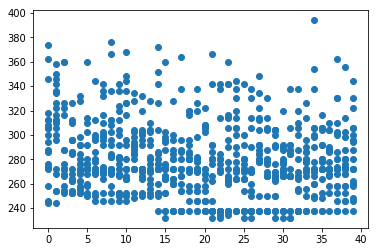

In [191]:
# calc_obj_fun(['B','A','D','C','E','F','G','H'])

#OBJECTIVE FUNCTIONS
def himmelblau(x, y):
    return ((x**2)+y-11)**2+(x+(y**2)-7)**2
def obj_fun_3(x):
    return (x/10)**5-5*(x/10)**4+5*(x/10)**3+5*(x/10)**2-6*(x/10)-1

solver = Genetic_solver()
# genetic params
solver.set_crossover_probability(0.95)
solver.set_mutation_probability(0.40)
solver.set_population_size(20)
solver.set_generations_count(40)
solver.set_tournament_size(5)
# solver.set_chromosome_length(60) # Not used in combinatorial problem
# solution params
solver.set_combinatorial_objective(calc_obj_fun)
solver.set_combinatorial_solution(['A','B','D','C','E','F','G','H']) # receives initial solution as input
# solve the fucker
solver.solve_combinatorial()
solver.display_generations_combinatorial()

In [181]:
solver.evaluate_combinatorial(solver.population[4])

318

In [146]:
solver.population[0]

['C', 'B', 'F', 'A', 'G', 'H', 'E', 'D']

In [147]:
a = [-10, -20, -30, 1, 2, 3, 4]
sorted(a, key=lambda x: x**2)

[1, 2, 3, 4, -10, -20, -30]

In [148]:
random.sample(list(enumerate(solver.population)), solver.k)

[(15, ['C', 'A', 'D', 'H', 'G', 'E', 'F', 'B']),
 (19, ['A', 'E', 'D', 'C', 'B', 'H', 'F', 'G']),
 (4, ['F', 'G', 'H', 'E', 'B', 'C', 'D', 'A'])]

In [149]:
# padres
a = solver.population[0]
b = solver.population[1]
ch1, ch2 = solver.crossover_combinatorial(a, b)
print(f'hijo 1  = {ch1}')
print(f'hijo 2  = {ch2}')
ch1_m = solver.mutate_child_combinatorial(ch1)
ch2_m = solver.mutate_child_combinatorial(ch2)
print(f'hijo 1m = {ch1_m}')
print(f'hijo 2m = {ch2_m}')

ordered solution = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
father a = ['C', 'B', 'F', 'A', 'G', 'H', 'E', 'D']
father b = ['A', 'B', 'E', 'C', 'D', 'F', 'G', 'H']
i = 2
j = 3
middle genome A: ['F']
middle genome B: ['E']
hijo 1  = ['A', 'B', 'E', 'C', 'D', 'F', 'G', 'H']
hijo 2  = ['A', 'B', 'F', 'C', 'D', 'E', 'G', 'H']
No mutation performed
No mutation performed
hijo 1m = ['A', 'B', 'E', 'C', 'D', 'F', 'G', 'H']
hijo 2m = ['A', 'B', 'F', 'C', 'D', 'E', 'G', 'H']


In [127]:
child = ['D', 'C', 'H', 'F', 'E', 'G', 'A', 'B']
i = 0
j = 3
print(child[:i])
print(child[i:j+1])
print(child[j+1:])
ch_mid = child[i:j+1]
new_child = child[:i]
new_child.extend(reversed(ch_mid))
new_child.extend(child[j+1:])
new_child

[]
['D', 'C', 'H', 'F']
['E', 'G', 'A', 'B']


['F', 'H', 'C', 'D', 'E', 'G', 'A', 'B']

In [128]:
[1, 2, 3][:0]

[]

In [184]:
a = {1, 2, 3}
b = {3, 4, 5}

In [188]:
a | b

{1, 2, 3, 4, 5}